In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
#print(os.listdir("input"))

# Any results you write to the current directory are saved as output.

## Load datasets

In [2]:
# load datasets
train = pd.read_csv('data_raw/train.csv')
test = pd.read_csv('data_raw/test.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_len = len(train)
test_copy = test.copy()

## Data Preprocess
As Cabin and Embarked has no correlations to survival, we just drop those columns later. 
See reference:
[Titanic [0.82] - [0.83]](https://www.kaggle.com/konstantinmasich/titanic-0-82-0-83)  
For Age and Fare, we fill the missing values with corresponding medians.


In [5]:
# combine train and test set
total = train.append(test)
total.isnull().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [6]:
total[total.Fare.isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
152,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [7]:
# fill the missing value for Fare column with median
total['Fare'].fillna(value = total[total.Pclass==3]['Fare'].median(), inplace = True)

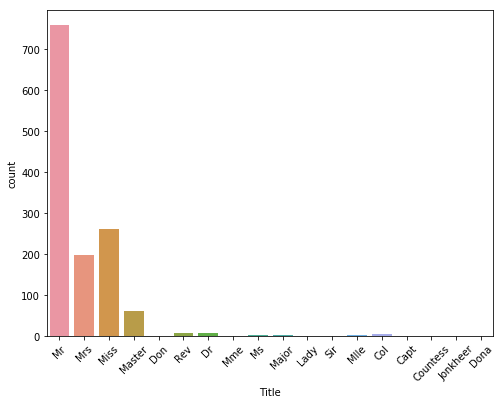

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# extract title from name, fill the missing value for Age column according to title's median
total['Title'] = total['Name'].str.extract('([A-Za-z]+)\.', expand=True)
# check distribution of title
plt.figure(figsize=(8,6))
sns.countplot(x= "Title",data = total)
plt.xticks(rotation='45')
plt.show()

In [9]:
# Replacing rare titles with more common ones
mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr', 'Don': 'Mr', 'Mme': 'Miss',
          'Jonkheer': 'Mr', 'Lady': 'Mrs', 'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}
total.replace({'Title': mapping}, inplace=True)

In [10]:
# fill the missing value for Age column with median of its title
titles = list(total.Title.unique())
for title in titles:
    age = total.groupby('Title')['Age'].median().loc[title]
    total.loc[(total.Age.isnull()) & (total.Title == title),'Age'] = age

In [11]:
# add family size as a feature
total['Family_Size'] = total['Parch'] + total['SibSp']

In [12]:
# This feature is from S.Xu, https://www.kaggle.com/shunjiangxu/blood-is-thicker-than-water-friendship-forever
total['Last_Name'] = total['Name'].apply(lambda x: str.split(x, ",")[0])
total['Fare'].fillna(total['Fare'].mean(), inplace=True)

default_survival_rate = 0.5
total['Family_Survival'] = default_survival_rate

for grp, grp_df in total[['Survived','Name', 'Last_Name', 'Fare', 'Ticket', 'PassengerId',
                           'SibSp', 'Parch', 'Age', 'Cabin']].groupby(['Last_Name', 'Fare']):
    
    if (len(grp_df) != 1):
        # A Family group is found.
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                total.loc[total['PassengerId'] == passID, 'Family_Survival'] = 1
            elif (smin==0.0):
                total.loc[total['PassengerId'] == passID, 'Family_Survival'] = 0

print("Number of passengers with family survival information:", 
      total.loc[total['Family_Survival']!=0.5].shape[0])

Number of passengers with family survival information: 420


In [13]:
for _, grp_df in total.groupby('Ticket'):
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            if (row['Family_Survival'] == 0) | (row['Family_Survival']== 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1.0):
                    total.loc[total['PassengerId'] == passID, 'Family_Survival'] = 1
                elif (smin==0.0):
                    total.loc[total['PassengerId'] == passID, 'Family_Survival'] = 0
                        
print("Number of passenger with family/group survival information: " 
      +str(total[total['Family_Survival']!=0.5].shape[0]))


Number of passenger with family/group survival information: 546


In [14]:
# add fare bins
total['Fare_Bin'] = pd.qcut(total['Fare'], 5,labels=False)
# add age bins
total['Age_Bin'] = pd.qcut(total['Age'], 4,labels=False)

In [15]:
# convert Sex to catergorical value
total.Sex.replace({'male':0, 'female':1}, inplace = True)

# only select the features we want
features = ['Survived','Pclass','Sex','Family_Size','Family_Survival','Fare_Bin','Age_Bin']
total = total[features]

In [16]:
# split total to train and test set
train = total[:train_len]
# set Survied column as int
x_train = train.drop(columns = ['Survived'])
y_train = train['Survived'].astype(int)

x_test = total[train_len:].drop(columns = ['Survived'])

## Feature Scailing

In [17]:
# Scaling features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

## Model Building

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
params = {'n_neighbors':[6,8,10,12,14,16,18,20],
         'leaf_size':list(range(1,50,5))}

# Using ROC_AUC as metric has a better result than using accuracy. 
gs = GridSearchCV(clf, param_grid= params, cv = 5,scoring = "roc_auc",verbose=1)
gs.fit(x_train, y_train)
print(gs.best_score_)
print(gs.best_estimator_)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.8813662235207279
KNeighborsClassifier(algorithm='auto', leaf_size=6, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=18, p=2,
           weights='uniform')


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    8.1s finished


In [19]:
preds = gs.predict(x_test)
result = pd.DataFrame({'PassengerId': test_copy['PassengerId'], 'Survived': preds})
result.to_csv('result.csv', index = False)

Reference:
1. [Blood is thicker than water & friendship forever](https://www.kaggle.com/shunjiangxu/blood-is-thicker-than-water-friendship-forever)
2. [Titanic [0.82] - [0.83]](https://www.kaggle.com/konstantinmasich/titanic-0-82-0-83)